# 3D Lithospheric Oblique Sasha A

In [1]:
import UWGeodynamics as GEO
import glucifer

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [3]:
# Characteristic values of the system
half_rate = 1.8 * u.centimeter / u.year
model_length = 500e3 * u.meter
model_width = 500e3 * u.meter
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK #earth interior temperature changes with depth aka thinkness of the model
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

In [4]:
Model = GEO.Model(elementRes=(12, 12, 6), 
                  minCoord=(0. * u.kilometer, 0. * u.kilometer, -160. * u.kilometer), 
                  maxCoord=(500. * u.kilometer, 500. * u.kilometer, 20. * u.kilometer), 
                  gravity=(0.0, 0.0, -9.81 * u.meter / u.second**2))
#change teh resolution to <= 4 km after testing the sceript


## Global definitions

In [5]:
Model.outputDir="outputs_folder"

In [6]:
Model.maxViscosity  = 5e23 * u.pascal * u.second
Model.minViscosity  = 1e19 * u.pascal * u.second
Model.stressLimiter = 300. * u.megapascal

In [7]:
Model.diffusivity = 1e-6 * u.metre**2 / u.second 
Model.capacity    = 100. * u.joule / (u.kelvin * u.kilogram)

In [8]:
#help Model.set_temperatureBCs

## Define Materials

The model has initially 4 materials (air, crust, mantle lithosphere and mantle). We add a fifth material for the sediment. Sediment will only appear if surface processes are turned on...(and if there is sedimentation of course)

In [9]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer3D(top=Model.top, bottom= 0. * u.kilometer))
crust = Model.add_material(name="Crust", shape=GEO.shapes.Layer3D(top=air.bottom, bottom=-40. * u.kilometer))
mantleLithosphere = Model.add_material(name="MantleLithosphere", shape=GEO.shapes.Layer3D(top=crust.bottom, bottom=-100. * u.kilometer))
mantle = Model.add_material(name="Mantle", shape=GEO.shapes.Layer3D(top=mantleLithosphere.bottom, bottom=Model.bottom))
#sediment   = Model.add_material(name="Sediment")

In [10]:
#help(Model.add_material)




In [11]:
# Fig = glucifer.Figure()
# Fig.Surface(Model.mesh, Model.projMaterialField, cullface=False, opacity=0.70)
# viewer = Fig.viewer(resolution=(1200,600))
# viewer = Fig.viewer(axis=True)
# viewer.window()


In [12]:
# Fig = glucifer.Figure()
# Fig.Points(Model.swarm, Model.materialField, cullface=False, opacity=1.)
# Fig.Mesh(Model.mesh)
# viewer = Fig.viewer(resolution=(1200,600))
# viewer = Fig.viewer(axis=True)
# viewer.window()



In [13]:
# Fig = Model.plot.material(script=["rotate z 30", "rotate x -60"], projected=True, figsize=(900,600))

### Material specific definitions


In [42]:
air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)
air.density = 1. * u.kilogram / u.metre**3

crust.density  = GEO.LinearDensity(reference_density=2800 * u.kilogram / u.metre**3)
mantleLithosphere.density  = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3)
mantle.density  = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3)
#sediment.density = 2300. * u.kilogram / u.metre**3

In [43]:
crust.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3
mantleLithosphere.radiogenicHeatProd = 0.037 * u.microwatt / u.meter**3
mantle.radiogenicHeatProd = 0.037 * u.microwatt / u.meter**3

#sediment.radiogenicHeatProd = 0.6 * u.microwatt / u.meter**3

### Viscous Rheologies

In [44]:
rh = GEO.ViscousCreepRegistry()

In [45]:
air.viscosity                = 1e19 * u.pascal * u.second
crust.viscosity              = 1e21 * u.pascal * u.second #rh.Gleason_and_Tullis_1995
crust.minViscosity = 1e20 * u.pascal * u.second
crust.maxViscosity = 5e23 * u.pascal * u.second
mantleLithosphere.viscosity  = rh.Karato_and_Wu_1990
mantle.viscosity             = rh.Karato_and_Wu_1990
#sediment.viscosity           = rh.Gleason_and_Tullis_1995



In [46]:
# rh.Hirth_et_al_2003

### Plasticities

We use a Drucker-Prager yield criterion with frictional weakening.

In [47]:
pl = GEO.PlasticityRegistry()

In [48]:
crust.plasticity = GEO.DruckerPrager(    #pl.Rey_et_al_2010_LowerCrust
    cohesion=20.*u.megapascal,
    cohesionAfterSoftening=20.*u.megapascal,
    frictionCoefficient=0.12,
    frictionAfterSoftening=0.02,
    epsilon1=0.01, epsilon2=1.0
    )
mantleLithosphere.plasticity = GEO.DruckerPrager(
    cohesion=20.*u.megapascal,
    cohesionAfterSoftening=20.*u.megapascal,
    frictionCoefficient=0.12,
    frictionAfterSoftening=0.02,
    epsilon1=0.01, epsilon2=1.0
    )
mantle.plasticity = GEO.DruckerPrager(
    cohesion=20.*u.megapascal,
    cohesionAfterSoftening=20.*u.megapascal,
    frictionCoefficient=0.12,
    frictionAfterSoftening=0.02,
    epsilon1=0.01, epsilon2=1.0
    )
# sediment.plasticity = GEO.DruckerPrager(
#     cohesion=20.*u.megapascal,
#     cohesionAfterSoftening=20.*u.megapascal,
#     frictionCoefficient=0.12,
#     frictionAfterSoftening=0.02,
#     epsilon1=0.01, epsilon2=1.0
#     )

## Passive Tracers

We create 2 sets of passive tracers to track the surface and the moho.

In [49]:
import numpy as np

xp = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), 100)
yp = np.linspace(GEO.nd(Model.minCoord[1]), GEO.nd(Model.maxCoord[1]), 100)

xp, yp = np.meshgrid(xp, yp)
xp = xp.flatten()
yp = yp.flatten()
zp = np.zeros(xp.shape)

surface_tracers = Model.add_passive_tracers(name="Surface", vertices=[xp, yp, zp])
moho_tracers = Model.add_passive_tracers(name="Moho", vertices=[xp, yp, zp+GEO.nd(mantleLithosphere.top)])

## Temperature Boundary Condition

Temperature is 293.15K at the top and 1603.15K at the bottom. Temperature is constant in the mantle and the air layers. 

In [50]:
#help(Model.set_temperatureBCs)

In [51]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=1603.15 * u.degK, 
                         materials=[(air, 273. * u.degK), (mantle, 1603. * u.degK)])


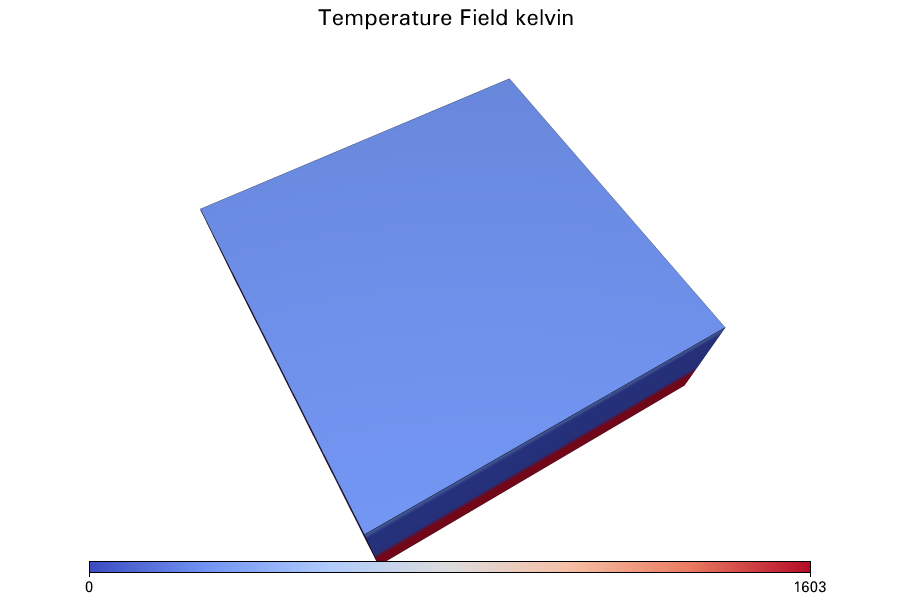

In [52]:
# Fig = Model.plot.temperature(script=["rotate z 30", "rotate x -30"], figsize=(900,600))

## Velocity Boundary Conditions

We pull on the left and right side. The back and front wall are freeslip. We use a pseudo isostatic support condition at the bottom.

In [53]:
Model.set_velocityBCs(left=[-2.0 * u.centimetre / u.year, 0.0 * u.centimetre / u.year, None],
                      right=[2.0 * u.centimetre / u.year, 0.0 * u.centimetre / u.year, None],
                      back=[None, 0., None],
                      front=[None, 0., None],
                      bottom=GEO.LecodeIsostasy(reference_mat=mantle.index,
                                                average=False))



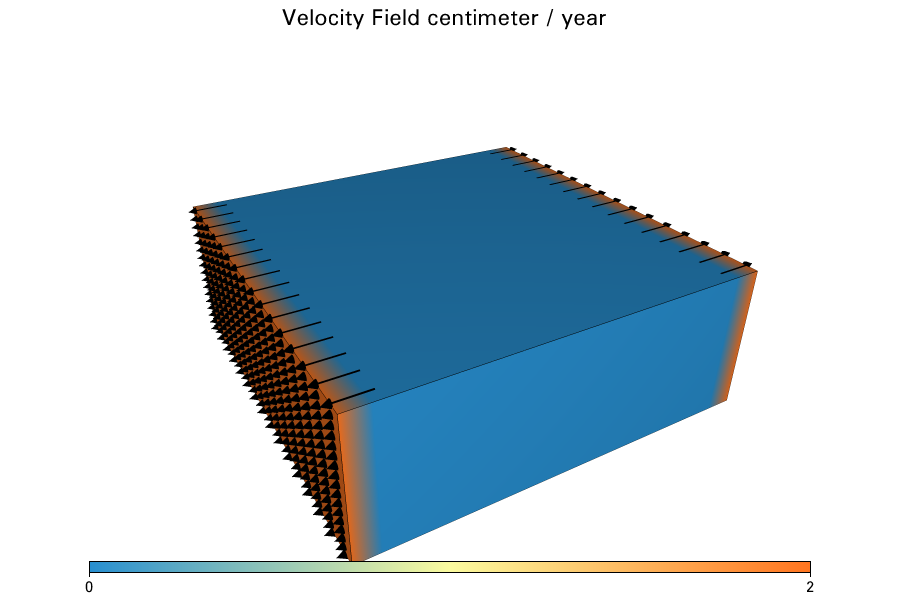

In [54]:
# Fig = Model.plot.velocityField(script=["rotate z 30", "rotate x -60"], figsize=(900,600))

## Initial Plastic Strain

An ellipsoidal shape with random damage is used to seed plastic deformation.

In [55]:
import numpy as np

def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))

maxDamage = 0.25
Model.plasticStrain.data[:] = maxDamage * np.random.rand(*Model.plasticStrain.data.shape[:])
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,0], (GEO.nd(Model.maxCoord[0] - Model.minCoord[0])) / 2.0, GEO.nd(5.0 * u.kilometer))
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,2], GEO.nd(-35. * u.kilometer) , GEO.nd(5.0 * u.kilometer))

In [56]:
# Fig = glucifer.Figure()
# Fig.Points(Model.swarm, Model.plasticStrain, fn_size=3.)
# lv = Fig.viewer(script=["rotate z 30", "rotate x -60"])
# lv.window()

<IPython.core.display.Javascript object>

## Plastic Strain Enveloppe

This is to create a buffer zone close to the left and right boundaries where plastic strain is not allowed to accumulate. You can comment the following cell if you think it is not needed. 

In [57]:
import underworld.function as fn

def post_hook():
    coords = fn.input()
    zz = coords[0] / (GEO.nd(Model.maxCoord[0]) - GEO.nd(Model.minCoord[0]))
    fact = fn.math.pow(fn.math.tanh(zz*20.0) + fn.math.tanh((1.0-zz)*20.0) - fn.math.tanh(20.0), 4)
    Model.plasticStrain.data[:] = Model.plasticStrain.data[:] * fact.evaluate(Model.swarm)

Model.postSolveHook = post_hook

# Surface Processes / BADLANDS

In [58]:
# Model.surfaceProcesses = GEO.surfaceProcesses.Badlands(airIndex=[air.index], sedimentIndex=sediment.index,
#                                            XML="ressources/badlands.xml", resolution=1. * u.kilometer, 
#                                            checkpoint_interval=0.01 * u.megayears)

## Solver, Model init

In [59]:
GEO.rcParams["solver"] = "mg" # This is the default so that line is technically not needed.

In [60]:
Model.init_model()

In [ ]:
# Fig = Model.plot.temperature(script=["rotate z 30", "rotate x -60"], figsize=(900,600))

In [ ]:
# Fig = Model.plot.pressureField(script=["rotate z 30", "rotate x -60"], figsize=(900,600))

In [ ]:
# Fig = Model.plot.velocityField(script=["rotate z 30", "rotate x -60"], figsize=(900,600))

In [ ]:
Model.run_for(20.0 * u.megayears, checkpoint_interval=0.01 * u.megayears)